In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

In [4]:
audio_path  = r'.\input.flac'

In [5]:
signal , sample_rate = librosa.load(audio_path, sr = None)

In [7]:
plt.figure(figsize = (14, 5))

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

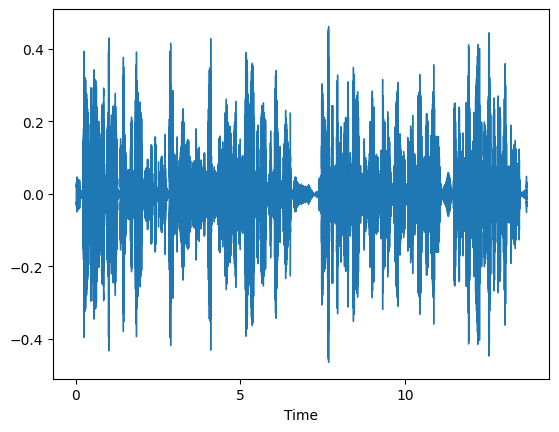

In [12]:
librosa.display.waveshow(signal, sr = sample_rate)

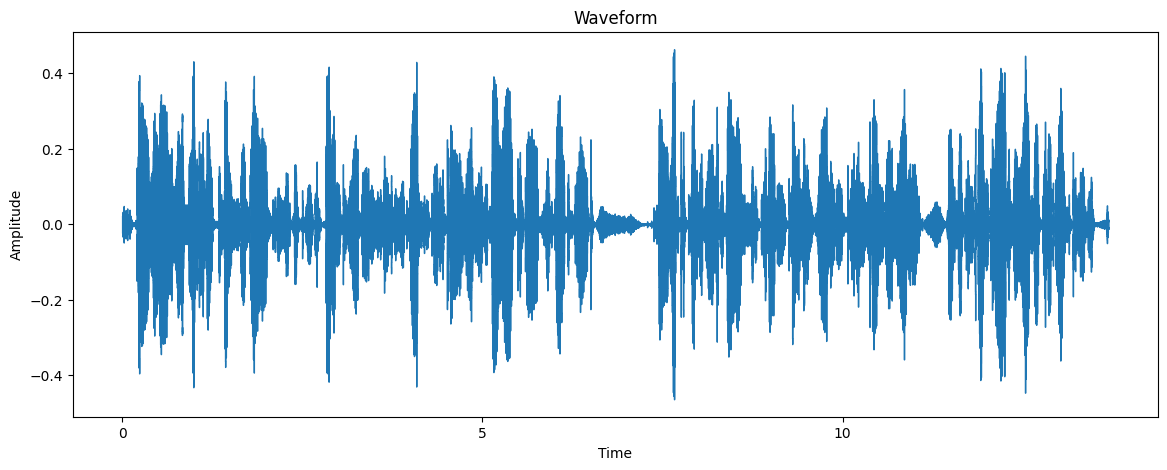

In [14]:
plt.figure(figsize = (14, 5))

librosa.display.waveshow(signal, sr = sample_rate)

plt.title('Waveform')

plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.show()

In [15]:
import numpy as np 


In [16]:
def reduce_noise(signal , noise_factor = 0.05): 

    signal_fft = np.fft.fft(signal)
    magnitude = np.abs(signal_fft)
    phase = np.angle(signal_fft)
    threshold = noise_factor * np.mean(magnitude)

    magnitude[magnitude < threshold] = 0

    denoised_signal = np.fft.ifft(magnitude * np.exp(1j * phase))   

    return np.real(denoised_signal)

denoised_signal = reduce_noise(signal)  

In [17]:
mfccs = librosa.feature.mfcc(y = denoised_signal, sr = sample_rate, n_mfcc = 13)

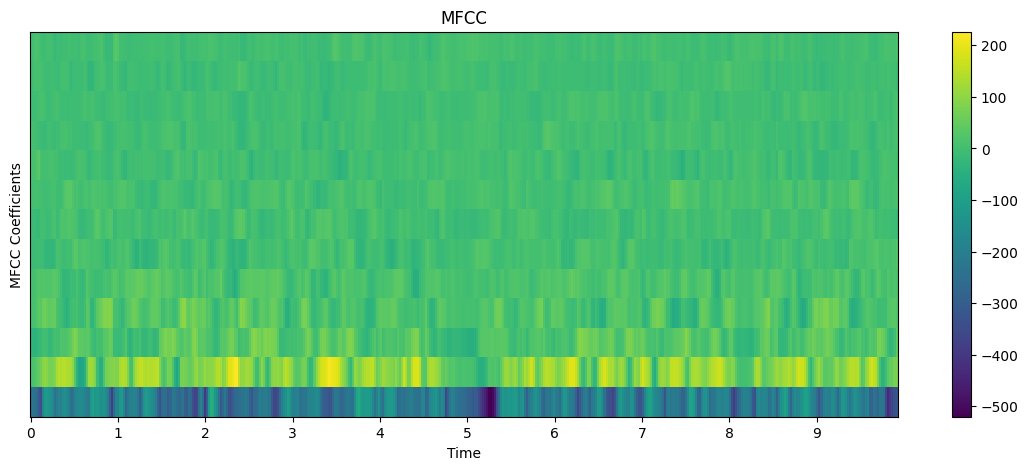

In [18]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfccs, x_axis = 'time' , cmap = 'viridis')
plt.colorbar()
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()


In [19]:
import os 

In [24]:
def process_audio_text_oair(audio_path , transcript): 
    signal , sr = librosa.load(audio_path , sr = None)
    deboised_signal = reduce_noise(signal)
    mfccs = librosa.feature.mfcc(y = deboised_signal, sr = sr, n_mfcc = 13)

    return mfccs , transcript

audio_dir = r'.\input.flac'

transcript_path = r'.\transcripts.txt'

audio_text_pairs = []  # Define the list here
with open(transcript_path, 'r') as f:
    for line in f:
        audio_filename, transcript = line.strip().split(' ', 1)
        mfccs, transcript = process_audio_text_oair(os.path.join(audio_dir, audio_filename), transcript)
        audio_text_pairs.append((mfccs, transcript))

In [25]:
import string

# Define character set (add more if needed)
characters = " " + string.ascii_lowercase  # space + lowercase a-z
char_to_index = {char: idx for idx, char in enumerate(characters)}
index_to_char = {idx: char for char, idx in char_to_index.items()}

def text_to_int_sequence(text):
    """Convert text to an integer sequence."""
    return [char_to_index[char] for char in text if char in char_to_index]

def int_sequence_to_text(sequence):
    """Convert integer sequence back to text."""
    return ''.join([index_to_char[idx] for idx in sequence])

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed
from tensorflow.keras.models import Model

def create_stt_model(input_dim, output_dim, units=128):
    # Define the input layer
    input_data = Input(name='input', shape=(None, input_dim))
    
    # Add a bidirectional LSTM layer
    x = tf.keras.layers.Bidirectional(LSTM(units, return_sequences=True))(input_data)
    x = tf.keras.layers.Bidirectional(LSTM(units, return_sequences=True))(x)
    
    # Dense layer to generate character predictions
    y_pred = TimeDistributed(Dense(output_dim, activation='softmax'), name='output')(x)
    
    # Define the model
    model = Model(inputs=input_data, outputs=y_pred)
    return model

# Model parameters
input_dim = 13  # Number of MFCC features
output_dim = len(char_to_index)  # Number of output characters

# Instantiate the model
model = create_stt_model(input_dim, output_dim)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None, 13)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 256)      │       145,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 256)      │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (TimeDistributed)        │ (None, None, 27)       │         6,939 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 546,587 (2.09 MB)

 Trainable params: 546,587 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# CTC Loss function
def ctc_loss(y_true, y_pred):
    return tf.nn.ctc_loss(labels=y_true, logits=y_pred, label_length=None, logit_length=None)


In [28]:
model.compile(optimizer='adam', loss=ctc_loss)


In [30]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad sequences to the same length
X = [x for x, _ in audio_text_pairs]
y = [text_to_int_sequence(y) for _, y in audio_text_pairs]

if X:  # Check if X is not empty
    X_padded = pad_sequences(X, padding='post', dtype='float32')
else:
    X_padded = np.array([])

if y:  # Check if y is not empty
    y_padded = pad_sequences(y, padding='post')
else:
    y_padded = np.array([])

# Train the model
if X_padded.size > 0 and y_padded.size > 0:
    history = model.fit(X_padded, y_padded, batch_size=32, epochs=10)
else:
    print("No data to train the model.")


No data to train the model.


In [32]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Learning rate scheduler to adjust learning rate based on validation loss
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Check if there is sufficient data for training and validation
if X_padded.size > 0 and y_padded.size > 0 and len(X_padded) > 1:
    history = model.fit(X_padded, y_padded, batch_size=32, epochs=20, validation_split=0.2, callbacks=[lr_scheduler])
else:
    print("Not enough data to train the model with the specified validation split.")


Not enough data to train the model with the specified validation split.
